# Drawdowns

* How much time is spent in large drawdowns
* Compare Bitcoin to S&P500 and Nasdaq
* Study individual bitcoin drawdowns and compare to Nasdaq since 70's

In [1]:
# Imports
%matplotlib inline
import quandl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [38]:
# Get price data 
bitcoin = quandl.get("BCHAIN/MKPRU")
bitcoin.columns = ['Close']
bitcoin = bitcoin.shift(-1) # data set has daily open, we want daily close
sp500 = pd.read_csv('^GSPC.csv', index_col = 0, parse_dates = [0])
nasdaq = pd.read_csv('NASDAQCOM.csv', index_col = 0, parse_dates = [0])
nasdaq.columns = ['Close']
nasdaq.index.name = 'Date'
nasdaq[nasdaq['Close'] == '.'] = np.NAN
nasdaq['Close'] = nasdaq['Close'].astype(float)
nasdaq['Close'].fillna(method = 'ffill', inplace = True)

In [47]:
# Remove the 0's and start on same date
bitcoin = bitcoin.loc['2010-08-17':]
sp500 = sp500.loc['2010-08-17':]
nasdaq = nasdaq.loc['2010-08-17':]

In [48]:
for df in [bitcoin, sp500, nasdaq]:
    max_so_far = np.maximum.accumulate(df['Close'])
    df['Drawdown%'] = (max_so_far - df['Close']) / max_so_far  * 100

In [49]:
for i in [5,10,20,30,40,50,60]:
    print i,
    for df in [bitcoin, sp500, nasdaq]:   
        print "{:,.1f}%".format(df[df['Drawdown%'] > i].size / float(df.size) * 100),
    print

5 89.9% 16.6% 25.1%
10 86.9% 5.0% 6.0%
20 79.5% 0.0% 0.0%
30 74.5% 0.0% 0.0%
40 69.8% 0.0% 0.0%
50 54.6% 0.0% 0.0%
60 44.5% 0.0% 0.0%


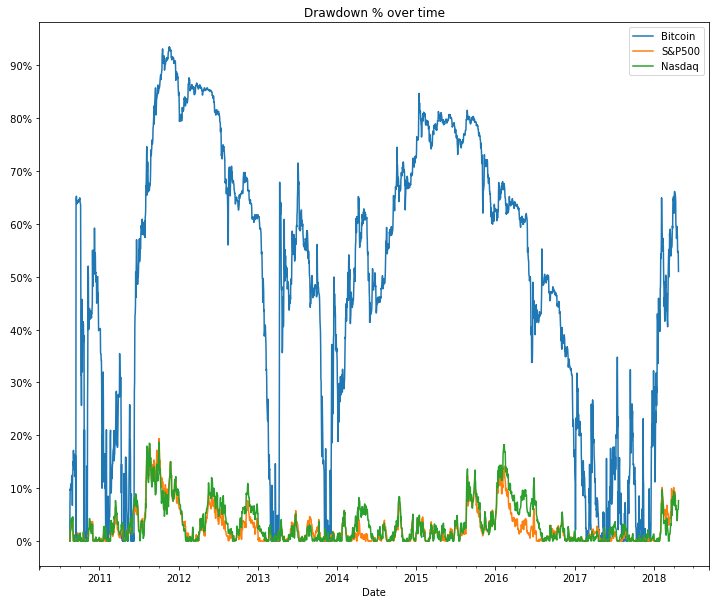

In [8]:
# Comparison of % drawdown over time
#%matplotlib qt5
fig, ax = plt.subplots(figsize=(12,10))
plt.title('Drawdown % over time')
bitcoin['Drawdown%'].plot(label = "Bitcoin", legend = True)
sp500['Drawdown%'].plot(label = "S&P500", legend = True)
nasdaq['Drawdown%'].plot(label = "Nasdaq", legend = True)
plt.yticks(np.arange(0,100,10))
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x) for x in vals])
fig.savefig("drawdowns.png", dpi=100, bbox_inches='tight')

In [9]:
# create a list of largest drawdowns recursively
# takes a Numpy array of prices (xs) and dates (ds)
# returns a list of tuples with drawdown size, start and end value, start and end date
def max_dd(xs, ds, depth = 5):
    if depth <= 0:
        return []
    try:
        i = np.argmax( (np.maximum.accumulate(xs) - xs) / xs ) # end of the period
        j = np.argmax(xs[:i]) # start of period
        dd = np.round( (1- xs[i]/xs[j]) * 100, 2)
        return [(dd,xs[j],xs[i],ds[j],ds[i])] + max_dd(xs[:j],ds[:j],depth-1) + max_dd(xs[i:],ds[i:],depth-1)
    except:
        return []

In [10]:
xs = np.array(bitcoin['Close'].dropna())
ds = bitcoin.index
dds = max_dd(xs, ds)
dds.sort()
dds = dds[::-1]
df = pd.DataFrame(dds, columns =['dd','high','low','highd','lowd'])
df['days'] = (df['lowd'] - df['highd'])

In [11]:
recoveryd = []
for index, row in df.iterrows():
    try:
        temp = bitcoin.loc[row['lowd']:]
        recoveryd.append(temp[temp['Close'] > row['high'] ].index[0])
    except:
        recoveryd.append(bitcoin.index[-1]) # has not recovered yet, use "todays" date
        continue

In [12]:
df['recoveryd'] = recoveryd
df['rdays'] = df['recoveryd'] - df['lowd']
df

,dd,high,low,highd,lowd,days,recoveryd,rdays
0,93.46,35.000000,2.290000,2011-06-09,2011-11-20,164 days,2013-03-03,469 days
1,84.67,1151.000000,176.500000,2013-12-03,2015-01-13,406 days,2017-02-23,772 days
2,71.49,237.990000,67.858440,2013-04-08,2013-07-04,87 days,2013-11-04,123 days
3,66.13,19498.683333,6603.876667,2017-12-16,2018-04-06,111 days,2018-04-25,19 days
4,65.20,0.175000,0.060900,2010-09-14,2010-09-16,2 days,2010-10-23,37 days
5,59.20,0.499999,0.204000,2010-11-06,2010-12-09,33 days,2011-01-30,52 days
6,39.98,7.220000,4.333330,2012-01-05,2012-02-18,44 days,2012-07-09,142 days
7,35.45,1.100000,0.710000,2011-02-09,2011-04-04,54 days,2011-04-17,13 days
8,34.80,2961.829613,1931.214300,2017-06-11,2017-07-16,35 days,2017-08-05,20 days
9,33.83,15.400000,10.189990,2012-08-16,2012-09-01,16 days,2013-01-17,138 days


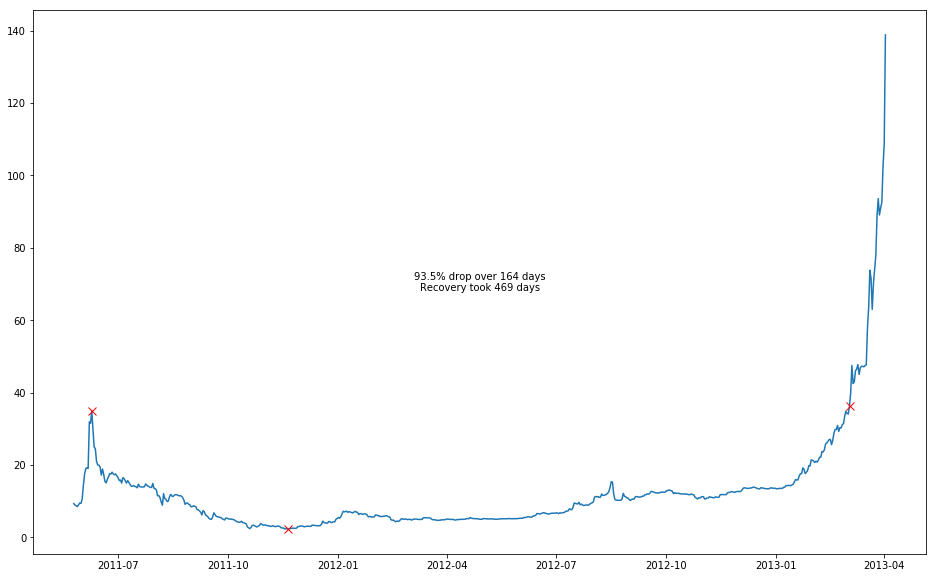

In [13]:
# plot each of the drawdowns to see the patterns

extra_days = 15 # add some extra days on either side

for index, row in df.iterrows():    
    if index > 0:
        break
    if row['dd'] < 25: # drawdowns of 25% or more
        break
    high = row['highd']
    recovery = row['recoveryd']
    low = row['lowd']
    start = high - timedelta(days=extra_days)
    end = recovery + timedelta(days=extra_days)
    if row['rdays'].days > 100:
        end += timedelta(days=extra_days)
    if row['rdays'].days > 500:
        end += timedelta(days=extra_days * 4)    
    fig, ax = plt.subplots(figsize=(16,10))
    ax.plot(bitcoin['Close'].loc[start:end].index, bitcoin['Close'].loc[start:end])       
    text = "%.1f%% drop over %d days\nRecovery took %d days" % (row['dd'],row['days'].days,row['rdays'].days)
    if index == 3:
        text = "%.1f%% drop over %d days\nBeen %d days so far" % (row['dd'],row['days'].days,row['rdays'].days)
    ax.plot([high, low, recovery], [bitcoin['Close'].loc[high], bitcoin['Close'].loc[low], bitcoin['Close'].loc[recovery]], 'x', color='Red', markersize=8)
    ax.text(0.5, 0.5,text, horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)
    #fig.savefig("drawdowns/bitcoin/" + high.strftime("%Y-%m-%d") + '.png', dpi=100)
    #plt.close(fig)

In [14]:
# Do same for Nasdaq
nasdaq = pd.read_csv('NASDAQCOM.csv', index_col = 0, parse_dates = [0])
nasdaq.columns = ['Close']
nasdaq.index.name = 'Date'
nasdaq[nasdaq['Close'] == '.'] = np.NAN
nasdaq['Close'] = nasdaq['Close'].astype(float)
nasdaq['Close'].fillna(method = 'ffill', inplace = True)

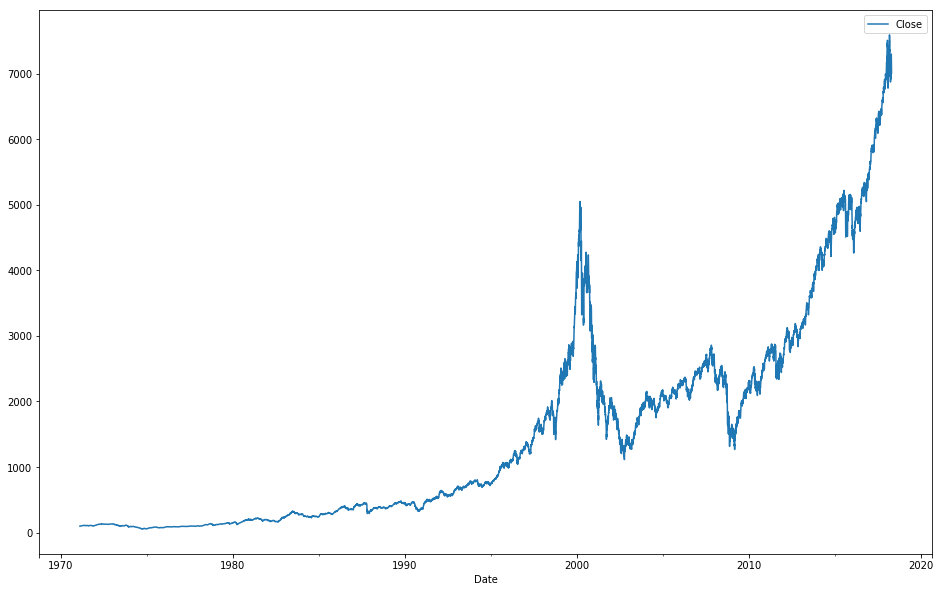

In [15]:
nasdaq.plot(figsize=(16,10))

In [16]:
# Find drawdowns
xs = np.array(nasdaq['Close'].dropna())
ds = nasdaq.index
dds = max_dd(xs, ds)
dds.sort()
dds = dds[::-1]
df = pd.DataFrame(dds, columns =['dd','high','low','highd','lowd'])
df['days'] = (df['lowd'] - df['highd'])
recoveryd = []
for index, row in df.iterrows():
    try:
        temp = nasdaq.loc[row['lowd']:]
        recoveryd.append(temp[temp['Close'] >= row['high'] ].index[0])
    except:
        recoveryd.append(nasdaq.index[-1]) # has not recovered yet, use "todays" date
        continue
df['recoveryd'] = recoveryd
df['rdays'] = df['recoveryd'] - df['lowd']
df

,dd,high,low,highd,lowd,days,recoveryd,rdays
0,77.93,5048.62,1114.11,2000-03-10,2002-10-09,943 days,2015-04-23,4579 days
1,59.90,136.84,54.87,1973-01-11,1974-10-03,630 days,1978-09-07,1435 days
2,55.63,2859.12,1268.64,2007-10-31,2009-03-09,495 days,2011-04-27,779 days
3,35.89,455.26,291.88,1987-08-26,1987-10-28,63 days,1989-08-03,645 days
4,33.00,485.73,325.44,1989-10-09,1990-10-16,372 days,1991-04-02,168 days
5,31.50,328.91,225.30,1983-06-24,1984-07-25,397 days,1986-01-07,531 days
6,29.55,2014.25,1419.12,1998-07-20,1998-10-08,80 days,1998-11-27,50 days
7,28.79,223.47,159.14,1981-05-29,1982-08-13,441 days,1982-11-04,83 days
8,18.71,2873.54,2335.83,2011-04-29,2011-10-03,157 days,2012-02-03,123 days
9,18.63,2153.83,1752.49,2004-01-26,2004-08-12,199 days,2004-12-14,124 days


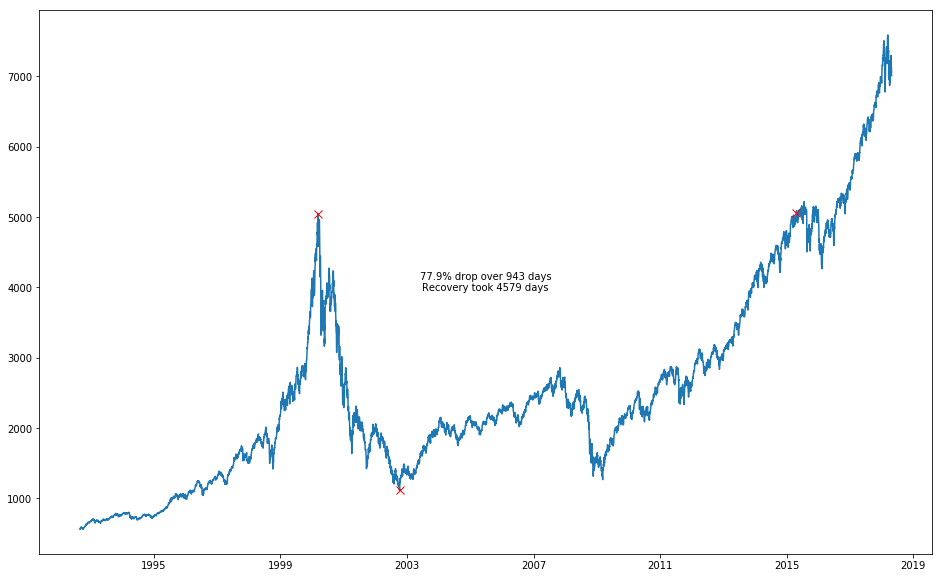

In [17]:
# plot each of the drawdowns to see the patterns

extra_days = 15 # add some extra days on either side

for index, row in df.iterrows():    
    if index > 0:
        break
    if row['dd'] < 25: # drawdowns of 25% or more
        break
    high = row['highd']
    recovery = row['recoveryd']
    low = row['lowd']
    start = high - timedelta(days=extra_days * row['rdays'].days / 25)
    end = recovery + timedelta(days=extra_days * row['rdays'].days / 25)
    fig, ax = plt.subplots(figsize=(16,10))
    ax.plot(nasdaq['Close'].loc[start:end].index, nasdaq['Close'].loc[start:end])       
    text = "%.1f%% drop over %d days\nRecovery took %d days" % (row['dd'],row['days'].days,row['rdays'].days)
    ax.plot([high, low, recovery], [nasdaq['Close'].loc[high], nasdaq['Close'].loc[low], nasdaq['Close'].loc[recovery]], 'x', color='Red', markersize=8)
    ax.text(0.5, 0.5,text, horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)
    #fig.savefig("drawdowns/nasdaq/" + high.strftime("%Y-%m-%d") + '.png', dpi=100)
    #plt.close(fig)